# Radar With Surface Obs
Plots radar and surface observations, using Pyart to read in the radar data, Matplotlib to plot it, and Metpy to read in and plot the station plots.

In [25]:
#from mpl_toolkits.basemap import Basemap, cm
import os.path
import sys
from matplotlib import rcParams
#from matplotlib.animation import ArtistAnimation
import matplotlib
import matplotlib.pyplot as plt
import pyart
from siphon.radarserver import RadarServer
from datetime import datetime, timedelta
from siphon.cdmr import Dataset
#import pyart
import numpy as np
import numpy.ma as ma
import netCDF4
import cartopy.crs as ccrs
import cartopy.feature as cfeature
#import numpy.ma as ma
#from cartopy.io.shapereader import Reader
#from cartopy.feature import ShapelyFeature
from siphon.catalog import TDSCatalog
from siphon.ncss import NCSS
from metpy.plots import StationPlot
from metpy.plots.wx_symbols import sky_cover
from metpy.calc import get_wind_components
from metpy.units import units
#import scipy.ndimage as ndimage

Direct RadarServer to the correct link to the Amazon S3 server with the radar data. The Amazon link only works for .edu domains, but the link below it will work for other domains for data within the past two weeks or so.

In [26]:
rs = RadarServer('http://thredds-aws.unidata.ucar.edu/thredds/radarServer/nexrad/level2/S3/')
#rs = RadarServer('http://thredds.ucar.edu/thredds/radarServer/nexrad/level2/IDD/')

Use RadarServer and Pyart to pull in a radar object for the scan we want.

In [27]:
query = rs.query()
dt = datetime(2017, 6, 12, 22, 0) # Our specified time
query.stations('KCYS').time(dt)
cat = rs.get_catalog(query)
for item in sorted(cat.datasets.items()):
    # Pull the actual Dataset object out
    # of our list of items and access over OPENDAP
    ds = item[1]
radar = pyart.io.nexrad_cdm.read_nexrad_cdm(ds.access_urls['OPENDAP'])
#Pull out only the lowest tilt
radar = radar.extract_sweeps([0])
#Pull the timestamp from the radar file
time_start = netCDF4.num2date(radar.time['data'][0], radar.time['units'])

Using Pyart, pull in location info and base reflectivity

In [28]:
rlons = radar.gate_longitude['data']
rlats = radar.gate_latitude['data']
cenlat = radar.latitude['data'][0]
cenlon = radar.longitude['data'][0]
#Pull reflectivity from the radar object
refl = radar.fields['reflectivity']['data']
#Mask noisy stuff below 20 dbZ
refl = ma.masked_less(refl, 20.)

Create a figure to plot our radar and stations on

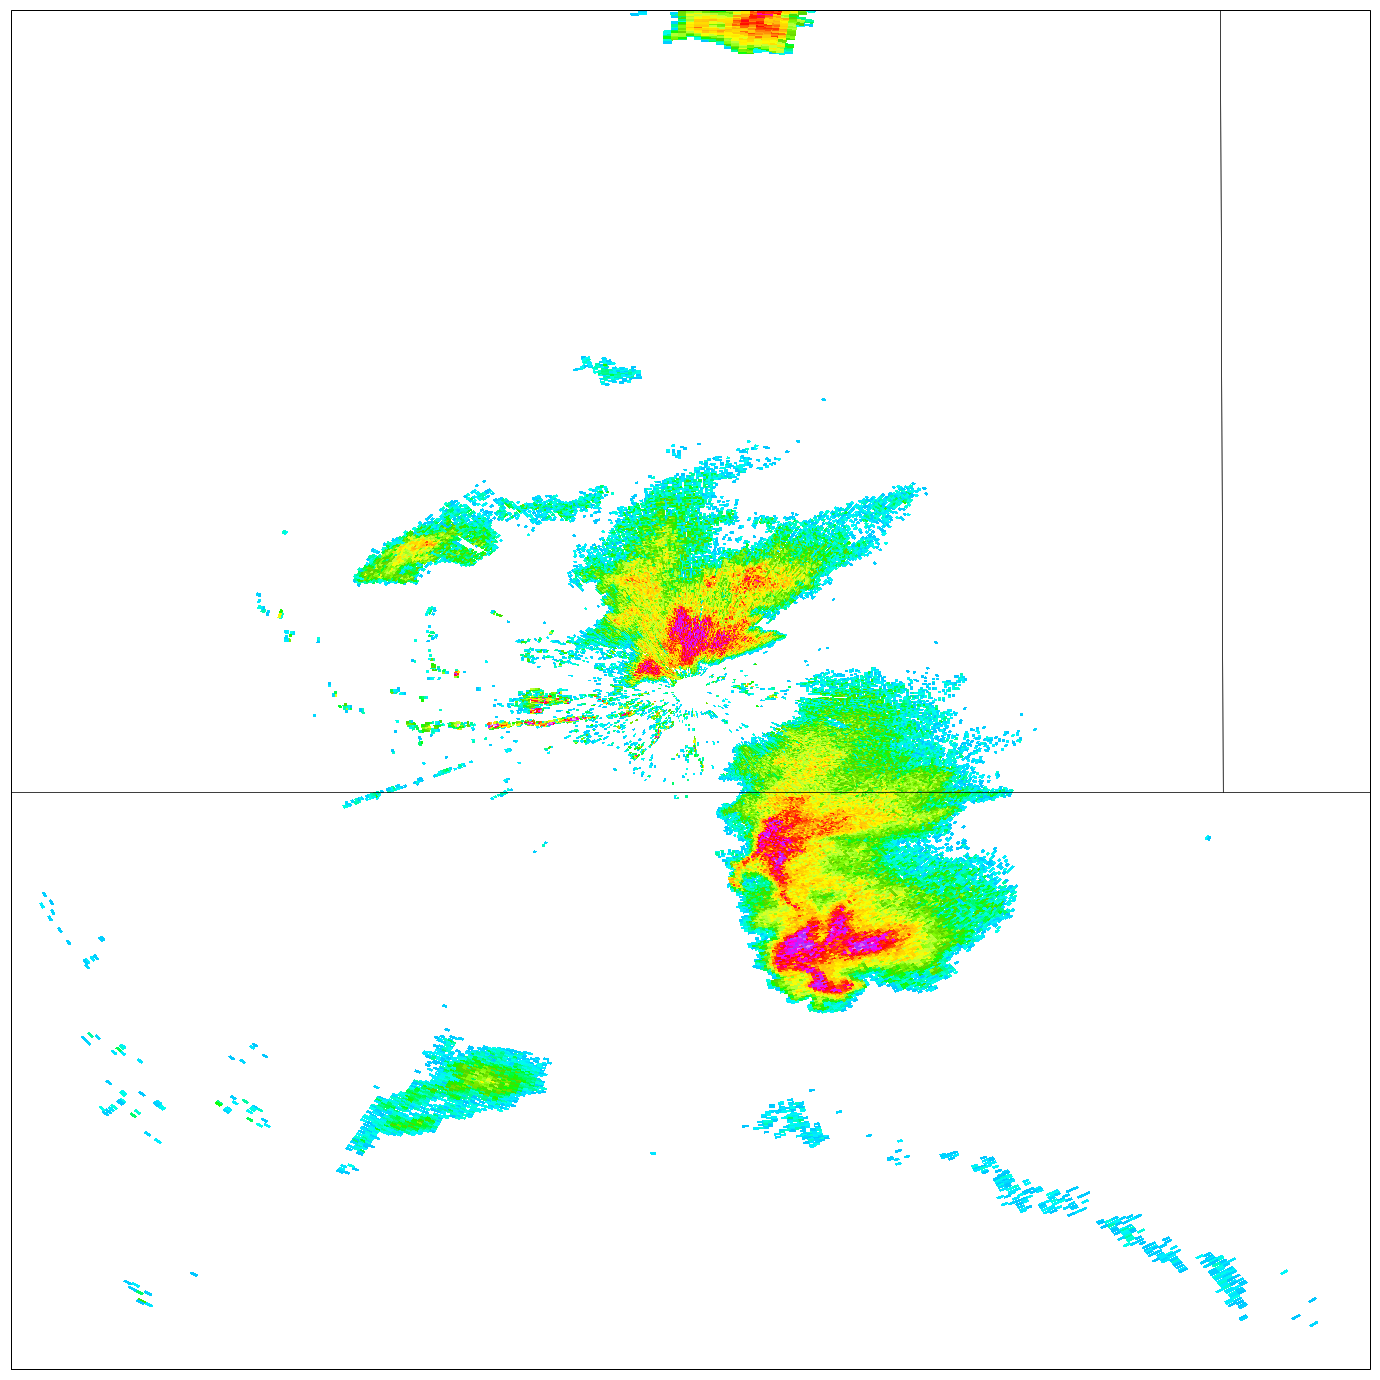

In [29]:
# Set up our projection
crs = ccrs.LambertConformal(central_longitude=-100.0, central_latitude=45.0)
# Set up our array of latitude and longitude values and transform to 
# the desired projection.
tlatlons = crs.transform_points(ccrs.LambertConformal(central_longitude=265, central_latitude=25, standard_parallels=(25.,25.)),rlons,rlats)
tlons = tlatlons[:,:,0]
tlats = tlatlons[:,:,1]
# Limit the extent of the map area to around the radar, must convert to proper coords.
LL = (cenlon-1.,cenlat-1.,ccrs.PlateCarree())
UR = (cenlon+1.,cenlat+1.0,ccrs.PlateCarree())
# Get data to plot state and province boundaries
states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lakes',
        scale='50m',
        facecolor='none')
#Read in state and county boundary shapefiles
#fname = 'cb_2016_us_county_20m/cb_2016_us_county_20m.shp'
#fname2 = 'cb_2016_us_state_20m/cb_2016_us_state_20m.shp'
#counties = ShapelyFeature(Reader(fname).geometries(),ccrs.PlateCarree(), facecolor = 'none', edgecolor = 'black')
#states = ShapelyFeature(Reader(fname2).geometries(),ccrs.PlateCarree(), facecolor = 'none', edgecolor = 'black')
#Create the figure
%matplotlib inline
fig=plt.figure(1,figsize=(30.,25.))
ax = plt.subplot(111,projection=ccrs.PlateCarree())
ax.coastlines('50m',edgecolor='black',linewidth=0.75)
ax.add_feature(states_provinces,edgecolor='black',linewidth=0.5)
#Add states/counties and set extent
#ax.add_feature(counties, edgecolor = 'black', linewidth = 0.5)
#ax.add_feature(states, edgecolor = 'black', linewidth = 1.5)
ax.set_extent([LL[0],UR[0],LL[1],UR[1]])
#Plot our radar data
refp = ax.pcolormesh(rlons, rlats, refl, cmap=plt.cm.gist_ncar, vmin = 10, vmax = 70)

Now let's add some station plots to our map!

In [31]:
# Point to the URL for the station data on the Unidata thredds server
metar_cat_url = 'http://thredds.ucar.edu/thredds/catalog/nws/metar/ncdecoded/catalog.xml? \
                 dataset=nws/metar/ncdecoded/Metar_Station_Data_fc.cdmr'
# Parse the xml
catalog = TDSCatalog(metar_cat_url)
metar_dataset = catalog.datasets['Feature Collection']
ncss_url = metar_dataset.access_urls['NetcdfSubset']
# Import ncss client
ncss = NCSS(ncss_url)
# Set date/time to be the time from our radar scan
start_time = datetime(time_start.year, time_start.month, time_start.day, time_start.hour, time_start.minute)
# Create a query to access the data
query = ncss.query()
query.lonlat_box(north=cenlat+1., south=cenlat-1., east=cenlon+1., west=cenlon-1)
query.time(start_time)
query.variables('air_temperature', 'dew_point_temperature', 'inches_ALTIM',
                'wind_speed', 'wind_from_direction', 'cloud_area_fraction')
query.accept('csv')
# Get the data
data = ncss.get_data(query)

Pull the station data out of our data object and add/convert units where needed.

In [32]:
# Access is just like netcdf4-python
lats = data['latitude'][:]
lons = data['longitude'][:]
tair = data['air_temperature'][:] * units('degC')
dewp = data['dew_point_temperature'][:] * units('degC')
tair = tair.to('degF').magnitude
dewp = dewp.to('degF').magnitude
slp = (data['inches_ALTIM'][:] * units('inHg')).to('mbar')

# Convert wind to components
u, v = get_wind_components(data['wind_speed'], data['wind_from_direction'] * units.degree)

# Need to handle missing (NaN) and convert to proper code
cloud_cover = 8 * data['cloud_area_fraction']
cloud_cover[np.isnan(cloud_cover)] = 10
cloud_cover = cloud_cover.astype(np.int)

Now we can plot everything together

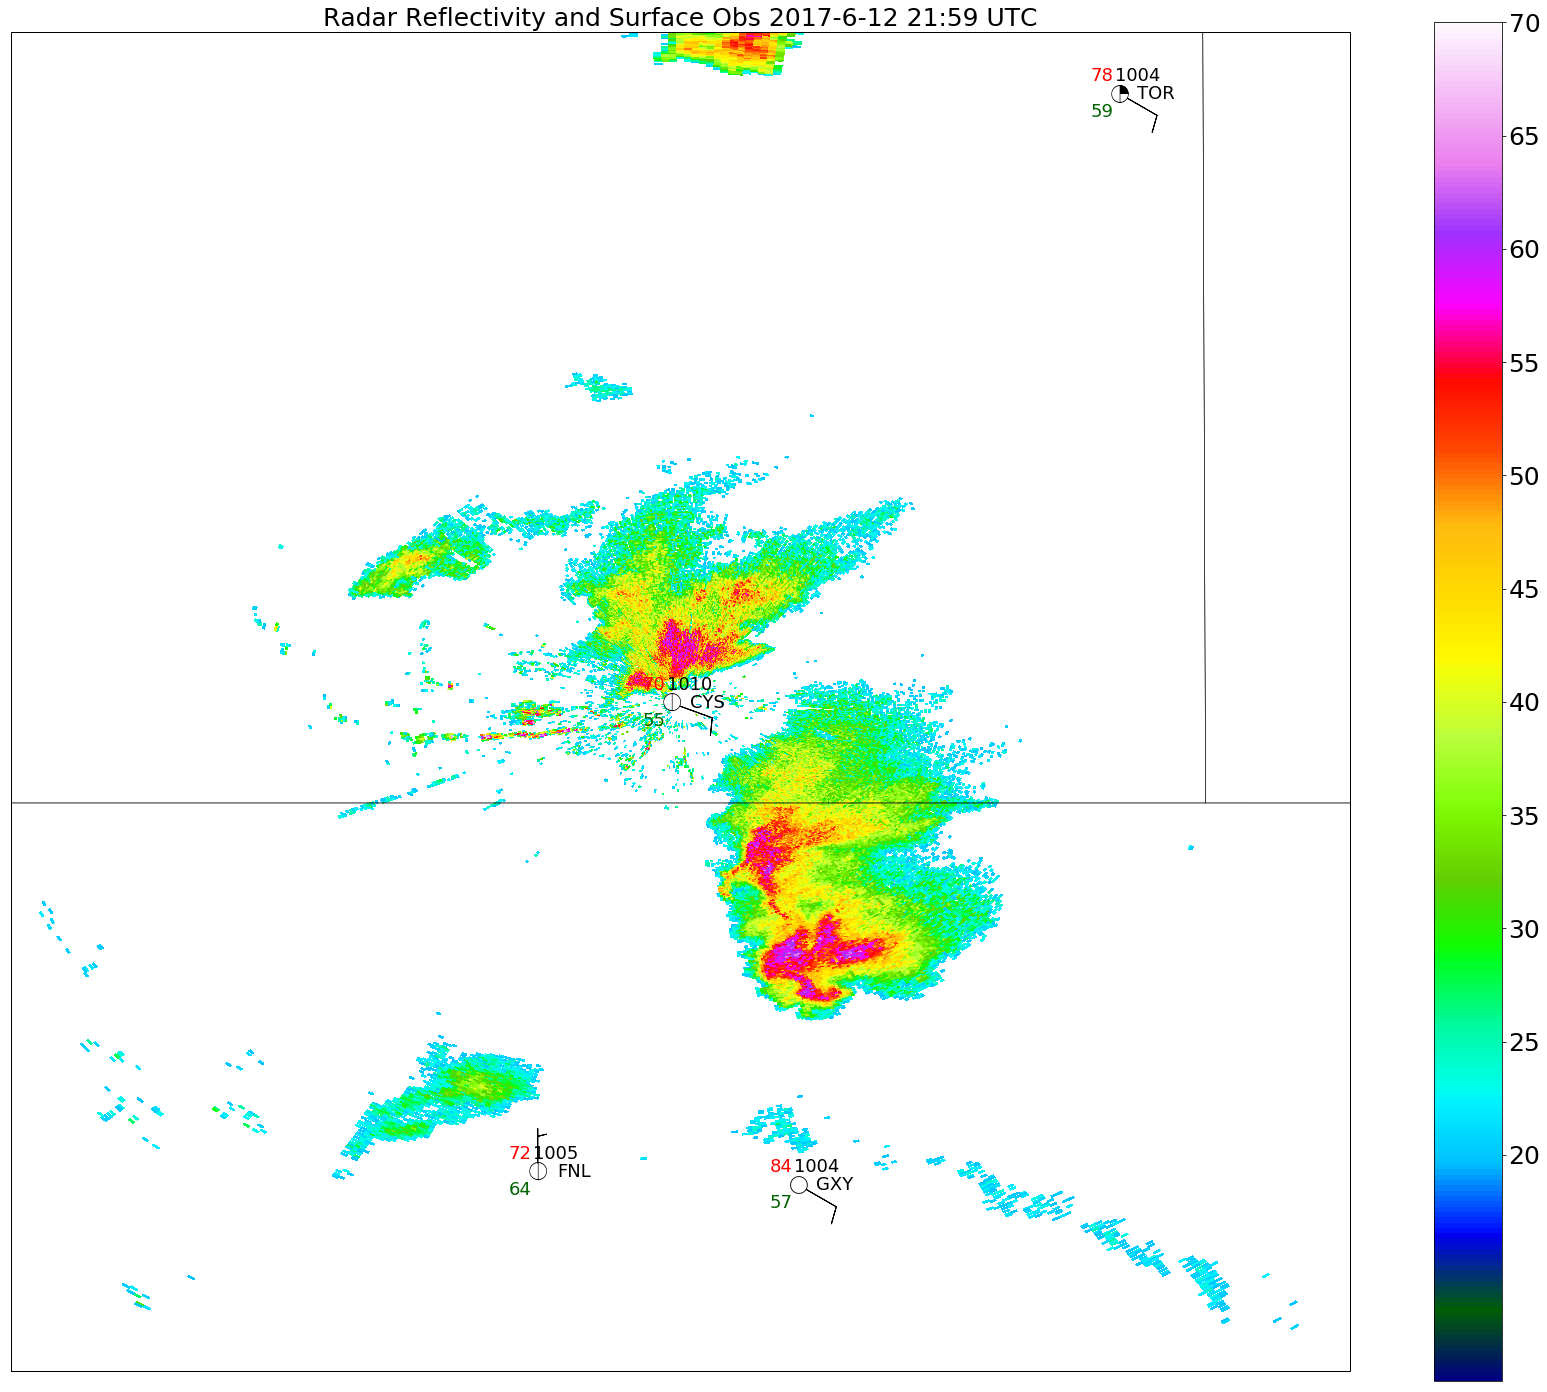

In [33]:
#Create the figure
fig=plt.figure(2,figsize=(30.,25.))
ax = plt.subplot(111,projection=ccrs.PlateCarree())
ax.coastlines('50m',edgecolor='black',linewidth=0.75)
ax.add_feature(states_provinces,edgecolor='black',linewidth=0.5)
#Add states/counties and set extent
#ax.add_feature(counties, edgecolor = 'black', linewidth = 0.5)
#ax.add_feature(states, edgecolor = 'black', linewidth = 1.5)
ax.set_extent([LL[0],UR[0],LL[1],UR[1]])
#Plot our radar data
refp = ax.pcolormesh(rlons, rlats, refl, cmap=plt.cm.gist_ncar, vmin = 10, vmax = 70)
# For some reason these come back as bytes instead of strings
stid = np.array([s.decode() for s in data['station']])
# Create a station plot pointing to an Axes to draw on as well as the location of points
stnp = stationplot = StationPlot(ax, lons, lats, transform=ccrs.PlateCarree(),
                          fontsize=18)
stnt = stationplot.plot_parameter('NW', tair, color='red')
stnd = stationplot.plot_parameter('SW', dewp, color='darkgreen')
stnpr = stationplot.plot_parameter('NE', slp)

# Add wind barbs
stnpb = stationplot.plot_barb(u, v)

# Plot the sky cover symbols in the center. We give it the integer code values that
# should be plotted, as well as a mapping class that can convert the integer values
# to the appropriate font glyph.
stns = stationplot.plot_symbol('C', cloud_cover, sky_cover)

# Plot station id -- using an offset pair instead of a string location
stntx = stationplot.plot_text((2, 0), stid)
cs = plt.colorbar(refp, ticks = [20,25,30,35,40,45,50,55,60,65,70],norm=matplotlib.colors.Normalize(vmin=20, vmax=70))

cs.ax.tick_params(labelsize=25)
plt.title('Radar Reflectivity and Surface Obs '+str(time_start.year)+'-'+str(time_start.month)+'-'+str(time_start.day)+
          ' '+str(time_start.hour)+':'+str(time_start.minute)+' UTC', size = 25)
plt.show()